<a href="https://colab.research.google.com/github/himalayahall/DATA602/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Recent advancements in NLP, most notable the NLG capabilities of Large Language Models (LLM) like ChatGPT, have taken the public imagination by storm. 

NLP (Natural Language Processing), NLU (Natural Language Understanding), and NLG (Natural Language Generation) are important subtopics of Machine 
Learning. 

**NLP** it involves programming computers to process massive volumes of language data. It involves numerous tasks that break down natural language into 
smaller elements in order to understand the relationships between those elements and how they work together. NLP focuses largely on converting text to 
structured data. It does this through the identification of named entities (a process called named entity recognition) and identification of word 
patterns, using methods like tokenization, stemming, and lemmatization, which examine the root forms of words.

**NLU** (Natural Language Understanding) is a subset of natural language processing, which uses syntactic and semantic analysis of text and speech to determine the meaning of a sentence. One of the primary goals of NLU is to teach machines how to interpret and understand language inputted by humans. 
It aims to teach computers what a body of text or spoken speech means. NLU leverages AI algorithms to recognize attributes of language such as sentiment, semantics, context, and intent. It enables computers to understand the subtleties and variations of language.

**NLG** (Natural Language Generation) is also a subset of NLP and is concerned with enabling machines to not just process and understand text but to generate text. While NLU focuses on computer reading comprehension, NLG enables computers to write. NLG is the process of producing a human language 
text response based on some data input (prompt).[[1]](#1)


## Project Goal

In this project we will explore the following:

**NLP**: create a classifier to classify product reviews as either original (presumably human created and authentic) or fake (presumably computer generated fake reviews). 

The motivation for using this dataset is that fake reviews are a major problem, as highlighted in the NPR article Why we usually can't tell when a review is fake, and it would be great to leverage NLP to address the problem.
Use Fastai to build the classifier. This will be accomplished by taking a pretrained language model and fine-tuning it to classify reviews. What we call a language model is a model that has been trained to guess what the next word in a text is (having read the ones before). This kind of task is called self-supervised learning: we do not need to give labels to our model, just feed it lots and lots of texts. It has a process to automatically get labels from the data, and this task isn't trivial: to properly guess the next word in a sentence, the model will have to develop an understanding of the English (or other) language.[2]

**NLU**: the English learned by the pretrained language model (Wikipedia) is slightly different from the English used for product reviews, so instead of jumping directly to the classifier, we will fine-tune our pretrained language model to the product corpus and then use that as the base for our classifier. This should (hopefully) result in better performance.

**NLG**: finally, having created a language model that has been fine-tuned for product reviews, we will use it to auto-generate fake reviews. This will be done by giving the model some starting text (prompt) and then asking the model to generate the rest (up to a maximum number of words).

### Data Sources

The generated [fake reviews dataset](https://osf.io/3vds7), containing 20k fake reviews and 20k real product reviews. OR = Original reviews (presumably human created and authentic); CG = Computer-generated fake reviews.


### Tools and Frameworks

- Google Collab
- Jupyter Notebook
- Fastai


#### References
<a id="1">[1]</a>
https://www.ibm.com/topics/natural-language-processing

<a id="2">[2]</a>
https://fastai.github.io/fastbook2e/book10.html

# Load data

In [24]:
import pandas as pd
import re

df = pd.read_csv('https://raw.githubusercontent.com/himalayahall/DATA602/main/fake%20reviews%20dataset.csv')

In [25]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB
None


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfortable. I love it!Very pretty"
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I've had mine for a couple of years"
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and feel of this pillow.
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it is a great product for the price! I"
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the set for two months now and have not been


Drop *category* and *rating* columns, rename *text_* to *text*.

In [26]:
df['text'] = df['text_']
df.drop(columns=['category', 'rating', 'text_'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   40432 non-null  object
 1   text    40432 non-null  object
dtypes: object(2)
memory usage: 631.9+ KB


In [27]:
df.head()

,label,text
0,CG,"Love this! Well made, sturdy, and very comfortable. I love it!Very pretty"
1,CG,"love it, a great upgrade from the original. I've had mine for a couple of years"
2,CG,This pillow saved my back. I love the look and feel of this pillow.
3,CG,"Missing information on how to use it, but it is a great product for the price! I"
4,CG,Very nice set. Good quality. We have had the set for two months now and have not been


## Accuracy and Baseline (Null) model

This dataset is balanced, i.e. number of *CG* labels = number of *OR* labels.

By definition, the *Null* model always predicts the majority class. As such, it provides an obvious baseline - i.e. any model worth considering **must** have accuracy greater than the *Null* model.

Accuracy is defined as $\frac{Correct\ Predictions}{Number \ of\ Observations}$. 

For a balanced dataset like ours, the *Null* model *accuracy* for our dataset is $50\%$. Consequently, our goal will be to create models with $Accuracy > 50\%$.

In [28]:
cat_size = df.groupby('label').size()
print(cat_size)

ham_prop = cat_size[0] / (cat_size[0] + cat_size[1])
print('Baseline (null model) accuracy: ' , ham_prop)

label
CG    20216
OR    20216
dtype: int64
Baseline (null model) accuracy:  0.5


### Other Important Metrics ###

Often, specially when dealing with unbalanced datasets, *accuracy* is not the best metric for evaluating model performance. 

For example, the prevalence of cancer in the general population for USA is roughly 5.5%. Accuracy of the *Null* model for such a dataset would be 94.5%. However, the *Null* model would be completely useless for actually detecting cancer!


**Precision** ($P$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false positives ($F_p$).
 
$P = \frac{T_p}{T_p+F_p}$

**Recall** ($R$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false negatives ($F_n$).

$R = \frac{T_p}{T_p+F_n}$ 

These quantities are also related to the **F1** score, which is defined as the harmonic mean of precision and recall.

$F1 = 2 \frac{P \times R}{P+R}$

## Fastai

We will use the fastai framework to build a large language model (LLM). Fastai is a great framework that enables rapid creation of predictive models without the need to write low level code in Tensorflow or PyTorch.

In [29]:
from fastai.data.all import *
from fastai.text.all import *

Create data loaders for classification, build **DataBlock** using **TextBlock** and **CategoryBlock**.

Set aside 20% data using **TrainTestSplitter** for model testing.

In [30]:
dls_cls = DataBlock(
            blocks=(
                TextBlock.from_df(text_cols=('text'), 
                        is_lm=False),
                CategoryBlock),
            get_x=ColReader('text'), 
            get_y=ColReader('label'),
            splitter=TrainTestSplitter(test_size=0.2, random_state=42, stratify=df.label)
        ).dataloaders(df)

Note - DataBlock automatically re-labels the *label* column as *category*.

In [31]:
dls_cls.show_batch(max_n = 5)

,text,category
0,"xxbos i compared this rawhide to & < a data - hook=""product - link - linked "" class=""a - link - normal "" href= "" / good - buddy - usa - rawhide - braided - sticks - for - dogs-7 - to-8 - inch-2 - count - pack - of-1 / dp / xxup b005gwvwja / ref = cm_cr_arp_d_rvw_txt?ie = utf8"">good xxmaj buddy xxup usa xxmaj rawhide xxmaj braided xxmaj sticks for xxmaj dogs , 7 to 8 - inch , 2 xxmaj count ( pack of 1 ) < / a > & for my 3 year old labradoodle . \n\n xxup where xxup it xxup is xxup made : xxmaj this is made in xxup china . xxmaj the & < a data - hook=""product - link - linked "" class=""a - link - normal "" href= "" / good - buddy - usa - rawhide -",OR
1,"xxbos xxmaj this is the camera that xxunk xxmaj labs gave the following rating for : \n "" no need for suspense : this new xxunk xxup mp sensor is simply the best xxup aps - c we have tested so far , sometimes able to compete even with very high - end full - frame cameras . \n\n xxmaj the overall score of the xxup xxunk puts it in the lead with 82 points -- more than 9 points better than the xxup xxunk or the xxmaj alpha 55 , and 16 points ahead of the xxmaj canon 7d or 60d . xxmaj the xxup xxunk is literally the best xxup aps - c performer for each segment , even in low xxup iso "" . \n xxmaj see their website at \n [ … ] \n\n i am no professional . i had used a basic xxup dslr",OR
2,"xxbos i have teenage boys , 3 big dogs , and 2 cats . i vacuum daily , and xxmaj i 'm hard on my vacuums . xxmaj this is my 3rd xxmaj hoover xxmaj wind xxmaj tunnel variation … and i like it the best , and the suction is fantastic , but it is heavy . xxmaj heavy to carry , heavy to push . \n\n xxup the xxup good : \n + xxmaj fabulous suction pulls up all the pet hair you did n't want to know you had . "" multi - xxunk "" suction ; previous model was "" dual xxmaj xxunk "" . \n + 7 settings for carpet height . xxmaj the previous model ( wind xxmaj tunnel 2 xxmaj pet xxmaj plus ) had 5 . xxmaj not sure that you need 7 but i guess some houses do . \n +",OR
3,"xxbos xxmaj on the plus side , this movie serves up the most beautiful images of xxmaj italy . xxmaj in fact , xxmaj italy is the star here . xxmaj and i completely enjoyed all of the xxmaj italian actors who played smaller roles . xxmaj it 's a pleasant , likeable , feel - good movie , and if that seems like xxunk with faint praise , that 's because it is .. xxmaj very much a chick flick , which is not a put - down . ( and when did movies about relationships , feelings , romance come to be something to xxunk at , anyway ? ) xxmaj there are no wizards here , no space aliens , no explosions , no threats to the future of the planet . xxmaj no violence at all . xxmaj the actors are all fine and xxmaj vanessa",OR
4,"xxbos i purchased the xxmaj olympus xxup vn 6200pc years ago , so i decided to compare it with the newer xxmaj olympus xxup vn-722pc . \n\n xxmaj at the time of purchase , i paid $ 43 for the xxup vn 6200pc ( i have no idea why its now listed for $ xxunk ) . xxmaj the xxup vn-722pc is currently $ xxunk . xxmaj so it costs a little more than the original charge for the xxup vn 6200pc . xxmaj what do i get for the added price ? \n\n xxmaj the xxup vn-722pc is slightly bigger with a xxup led screen that is almost double the size of my old recorder . xxmaj this makes it easier to read all of the settings . \n\n xxmaj both have lightweight plastic cases but seem sturdy enough to weather the xxunk usage of the average person .",OR


## Text Classifier

Create classifier. Notice,  there is no need to  pre-process text data for the classifier, e.g. create word embeddings, the framework does that automatically.

Here we are using [AWD_LST]([https://arxiv.org/pdf/1708.02182.pdf]) (averaged weght-dropped long-short term memory) model architecture.

In [32]:
learner = text_classifier_learner(dls_cls, 
                                    AWD_LSTM, 
                                    drop_mult=0.5, 
                                    metrics=[accuracy, Precision(), Recall(), F1Score()])

Calculate the optimal learning rate hyper-parameter. This will greatly influence how quickly the model converges.

SuggestedLRs(valley=0.007585775572806597)

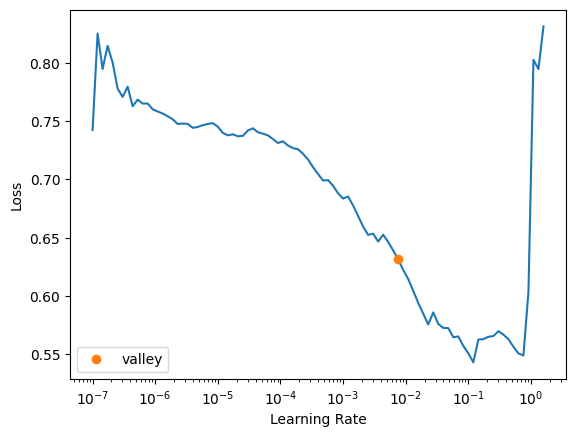

In [33]:
lr = learner.lr_find()
lr

Fine tune model for 3 epochs using the optimal learning rate.

In [34]:
learner.fine_tune(3, lr[0])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.358230,0.382557,0.841227,0.963075,0.709622,0.817146,01:07


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.238202,0.234461,0.909732,0.986205,0.831066,0.902013,02:20
1,0.161826,0.180798,0.926549,0.990054,0.861736,0.921449,02:19
2,0.108323,0.186942,0.926796,0.993988,0.858768,0.921444,02:20



Show a few predictions on training data. Note - predictions are put in a new *category*_ column.

In [ ]:
learner.show_results()

## Interpret results

Our classification model has $accuracy = 92\%$, significantly higher than the *Null* model ($50\%$)! 

Although *precision* is outstanding ($99\%$), *recall* is much lower ($85\%$).

Note - the model was tuned using GPUs, tuning on CPUs will take significantly longer (hours).

Looking at the confusion matrix, it seems the model is misclassifying a much larger number of ORs (original reviews) compared to CGs (computer generated).

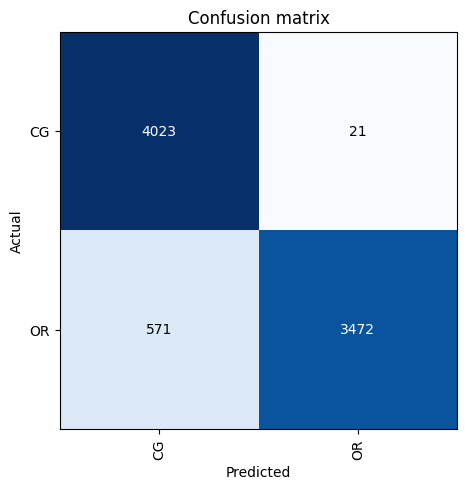

In [35]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

## Saving and loading model

At this point, if we wanted, we could save the model and it's trained weights. Later, the saved model could be loaded for making predictions.

In [36]:
learner.save('pretrained')

Path('models/pretrained.pth')

In [37]:
learner.load('pretrained')

# Language Model (ULMFiT approach)

The pretrained model in the previous section is called a language model. It was pretrained on Wikipedia on the task of guessing the next word, after reading all the words before. 

Notice, we are glossing over the details of exactly how many words are considered in making the prediction, what is the $loss function$, which $optimizer$ to use to fit the model, etc. Fastai selects intelligent defaults for all these paramaters are more.

We got great results by directly fine-tuning this language model to a movie review classifier, but can we do even better?

In general, with one extra step, we might do better: the Wikipedia English is slightly different from the English in our email corpus. So instead of jumping directly to the classifier, we could fine-tune our pretrained language model to the review corpus and use that as the base for our classifier.

We create the data loader for language modeling by setting $is\_lm=True$ . We set aside 10% data using **RandomSplitter** for model validation.

In [39]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df(text_cols=('text'), 
                             is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(valid_pct=0.1, seed=12345)
    ).dataloaders(df, bs=64)

In [40]:
dls_lm.show_batch(max_n = 10)

,text,text_
0,"xxbos i gave this rating because when the story ended , i was completely thrown off guard . i still am a little confused . xxbos xxmaj love military - type novels and a few of the characters are just too real . \n\n xxmaj the premise of the xxbos i love this product ! xxmaj the sound is amazing . xxmaj it is very smooth and my son loves it!great product","i gave this rating because when the story ended , i was completely thrown off guard . i still am a little confused . xxbos xxmaj love military - type novels and a few of the characters are just too real . \n\n xxmaj the premise of the xxbos i love this product ! xxmaj the sound is amazing . xxmaj it is very smooth and my son loves it!great product ."
1,"over the place . xxmaj made it much easier to collect them and start hitting again . xxbos xxmaj outstanding product -- i needed a place to feed my skinny cats at their leisure , feed my handicapped kitten , and keep my fat cat on a diet . xxmaj this works xxup great -- skinny cats love to play all over and jump up to the top house to feed when","the place . xxmaj made it much easier to collect them and start hitting again . xxbos xxmaj outstanding product -- i needed a place to feed my skinny cats at their leisure , feed my handicapped kitten , and keep my fat cat on a diet . xxmaj this works xxup great -- skinny cats love to play all over and jump up to the top house to feed when they"
2,"liked it so much i decided to get one for myself , too . xxmaj lightweight but well constructed . xxmaj pack heavy items like shoes in bottom to prevent it being top heavy and tipping over . xxbos xxmaj it fits well . xxmaj no pains after walking 10 km per round in my golf course , it is my favorite of all my 8 pairs of golf shoes , it","it so much i decided to get one for myself , too . xxmaj lightweight but well constructed . xxmaj pack heavy items like shoes in bottom to prevent it being top heavy and tipping over . xxbos xxmaj it fits well . xxmaj no pains after walking 10 km per round in my golf course , it is my favorite of all my 8 pairs of golf shoes , it seats"
3,". i can dry my whole body off and the towel will still be dry enough for me to use it to put my hair up in a xxunk . xxmaj this xxup never happened with my traditional cotton towels , which is why i always had to buy , wash , and tote around two towels ( not to mention that they never dried fast enough and got to stinking in","i can dry my whole body off and the towel will still be dry enough for me to use it to put my hair up in a xxunk . xxmaj this xxup never happened with my traditional cotton towels , which is why i always had to buy , wash , and tote around two towels ( not to mention that they never dried fast enough and got to stinking in humid"
4,xxup d810 xxup ii was the first that i had ever owned . xxmaj the xxmaj canon xxup d810 xxup ii is very compact and has a lot of features . xxmaj the camera features are very intuitive and easy to use . i love the fact that the lens hood is removable . i am very happy with the camera and will purchase it again . i have used the camera,d810 xxup ii was the first that i had ever owned . xxmaj the xxmaj canon xxup d810 xxup ii is very compact and has a lot of features . xxmaj the camera features are very intuitive and easy to use . i love the fact that the lens hood is removable . i am very happy with the camera and will purchase it again . i have used the camera for
5,was well written . xxmaj the story was told very well . xxmaj the characters were interesting and you felt like you were part of the story . xxmaj it was a good read . i ca n't imagine what to say about this book . xxmaj i 'm not a fan of most of the books in the series . xxmaj but i love this one . xxmaj this book is,well written . xxmaj the story was told very well . xxmaj the characters were interesting and you felt like you were part of the story . xxmaj it was a good read . i ca n't imagine what to say about this book . xxmaj i 'm not a fan

Next we create a language model learner.

For metrics, we use Perplexity (lower is better: among how many words the model is confused at predicting next word).

In [41]:
lm_learner = language_model_learner(
            dls_lm, 
            AWD_LSTM, 
            wd=0.1,
            metrics=[Perplexity()]).to_fp16()

Once more, we find the optimal learning rate.

SuggestedLRs(valley=0.004365158267319202)

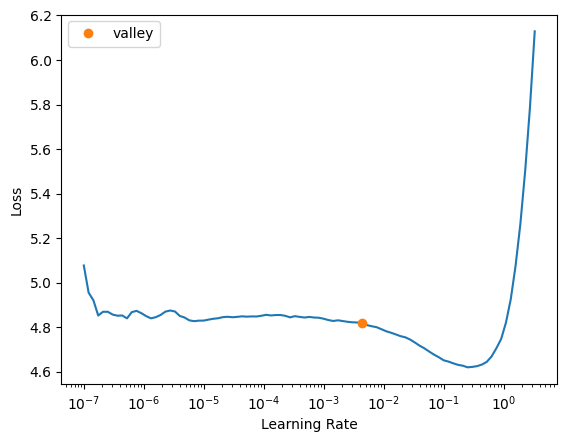

In [42]:
lr = lm_learner.lr_find()
lr

Next, we train the model for one epoch. By default, aside from the final layers, other inner layers of the model are $frozen$. In other words, the pre-trained language model is kept intact, in essence this is **transfer learning**.

In [43]:
lm_learner.fit_one_cycle(1, lr[0])

epoch,train_loss,valid_loss,perplexity,time
0,3.727202,3.437203,31.099848,02:53


Save language model state after 1 epoch.

In [44]:
lm_learner.save('1epoch')

Path('models/1epoch.pth')

Next, we unfreeze all layers of model for futher tuning.

In [45]:
lm_learner.unfreeze()

As before, find the optimal learning rate.

SuggestedLRs(valley=0.0005754399462603033)

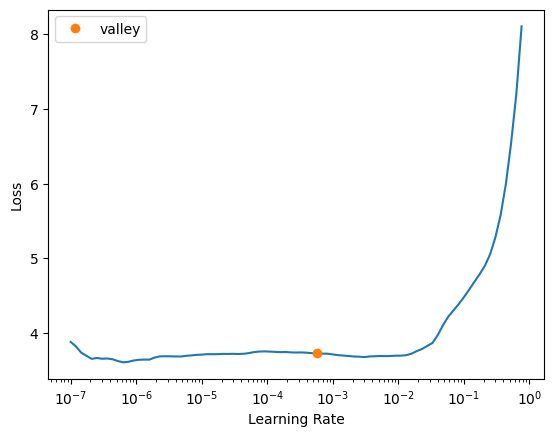

In [46]:
lr = lm_learner.lr_find()
lr

Train model for 4 epochs.

In [47]:
lm_learner.fit_one_cycle(4, lr[0])

epoch,train_loss,valid_loss,perplexity,time
0,3.399747,3.206247,24.686266,03:04
1,3.235348,3.079380,21.744907,03:01
2,3.148891,3.028229,20.660620,03:02
3,3.088566,3.018462,20.459808,03:02


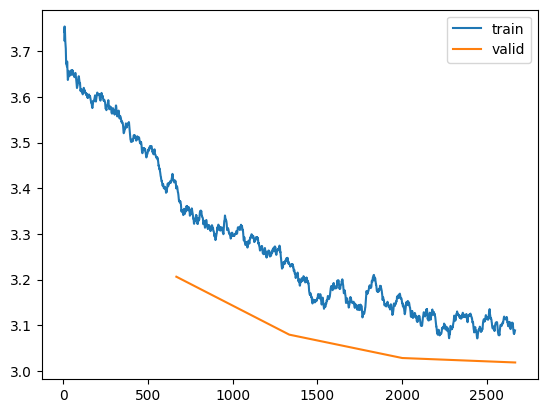

In [48]:
lm_learner.recorder.plot_loss()

Save the fully tuned model.

In [49]:
lm_learner.save_encoder('finetuned')

Now we can use the new LLM to build a classifier. 

Create DataLoaders for classification using the domain specific language model. Notice, we set $is\_lm=False$ and use the vocabulary list from the LLM by setting $vocab=dls\_lm.vocab$.

In [50]:
dls_cls = DataBlock(
            blocks=(TextBlock.from_df(text_cols=('text'), 
                              is_lm=False, 
                              vocab=dls_lm.vocab), 
            CategoryBlock),
            get_x=ColReader('text'),
            get_y=ColReader('label'), 
            splitter=RandomSplitter(valid_pct=0.2, seed=12345)
            ).dataloaders(df, bs=64)

In [51]:
dls_cls.show_batch(max_n=3)

,text,category
0,"xxbos i compared this rawhide to & < a data - hook=""product - link - linked "" class=""a - link - normal "" href= "" / good - buddy - usa - rawhide - braided - sticks - for - dogs-7 - to-8 - inch-2 - count - pack - of-1 / dp / xxup b005gwvwja / ref = cm_cr_arp_d_rvw_txt?ie = utf8"">good xxmaj buddy xxup usa xxmaj rawhide xxmaj braided xxmaj sticks for xxmaj dogs , 7 to 8 - inch , 2 xxmaj count ( pack of 1 ) < / a > & for my 3 year old labradoodle . \n\n xxup where xxup it xxup is xxup made : xxmaj this is made in xxup china . xxmaj the & < a data - hook=""product - link - linked "" class=""a - link - normal "" href= "" / good - buddy - usa - rawhide -",OR
1,"xxbos xxmaj tony xxmaj randall stars in xxup will xxup success xxup spoil xxup rock xxup hunter ? opposite xxmaj jayne xxmaj mansfield . xxmaj with her hair xxunk as white as a xxmaj xxunk 's wig , xxmaj jayne seems a poor xxmaj marilyn xxmaj monroe caricature whose tendencies to squeak , xxunk and bubble can be downright annoying . \n\n xxmaj xxunk xxmaj ad man xxmaj rock xxunk about his new business venture : "" that 's right xxmaj sweetie , xxmaj i 'm president of xxmaj xxunk xxmaj marlowe xxmaj productions , xxmaj inc . , but xxmaj miss xxmaj marlowe is the titular head . "" xxmaj the ' t ' word brings a loud xxunk from xxmaj mansfield that sounds like a bus trying to slow down with no brake pads . \n\n xxmaj the story opens with great xxunk a demonstration of both xxmaj",OR
2,"xxbos xxmaj the xxmaj secret xxmaj life of xxmaj walter xxmaj mitty is a book for xxunk , lovers and the xxunk boy in all of us . i lived at home until i was a vine - xxunk 27 , so believe me i can relate to xxmaj james xxmaj xxunk xxmaj mitty . xxmaj and xxmaj i ve always been a fond of a good daydream . xxmaj lets see what comes to me now : \n\n xxmaj i m a powerful land baron with an eye patch . xxmaj nay , a xxunk samurai lord . xxmaj no , xxmaj i m an oil tycoon . xxmaj fabulously rich , silver - haired , xxunk - eyed and what s this ? xxmaj i m in turbulent fight with my lover , no my sister , no my lover and her xxunk son . xxmaj he has",OR


Create text classification learner and use the LLM as the encoder.

In [52]:
learn = text_classifier_learner(dls_cls, 
                                AWD_LSTM, 
                                drop_mult=0.5, 
                                metrics=[accuracy, Precision(), Recall(), F1Score()])
learn = learn.load_encoder('finetuned')

Find the optimal learning rate.

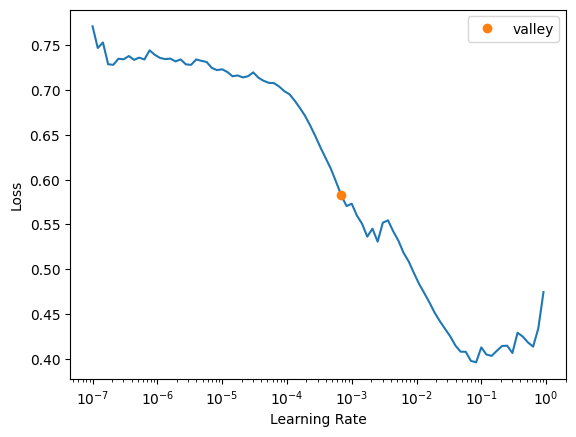

In [53]:
lr = learn.lr_find()

And tune the model for 3 epochs.

The new model has significantly greater *accuracy*, *recall*, and *F1 Score*. However,  *precision* is slightly lower.

In [54]:
learn.fine_tune(3, lr[0])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.198321,0.134412,0.951026,0.945913,0.955827,0.950844,01:08


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.196441,0.115174,0.958818,0.963421,0.953082,0.958224,02:21
1,0.136409,0.094703,0.965001,0.969018,0.960070,0.964523,02:22
2,0.147613,0.092665,0.966238,0.966051,0.965810,0.965930,02:22


 The confusion matrix shows the new model has performed better overall. It is more balanced in it's misclassifications - it has misclassified 136 CGs (previously 21) and 137 ORs (previously 571).

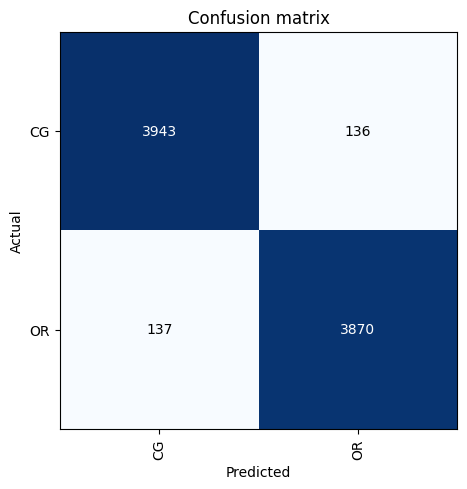

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Finally, let's use the LLM for text generation (NLG). Text generation involves prompting with some text and asking the model to generate additional text.

In [57]:
# TEXT = "Free promotion"
# N_WORDS = 40
# N_SENTENCES = 5
# preds = [lm_learner.predict(TEXT, N_WORDS, temperature=0.75)
# for _ in range(N_SENTENCES)]
# print("\n".join(preds))
N_WORDS = 40

PROMPTS = ["missing information on how to use it", 
           "love it, a great upgrade from ", 
           "let me tell you i do not like"]

preds = [lm_learner.predict(p, N_WORDS, temperature=0.75) for p in PROMPTS]

for idx in range(len(PROMPTS)):
  print(preds[idx])

missing information on how to use it . Very easy to use . 

 Pros : 

 -the cable is very large 
 -the cable is not very large 

 The cable is not adjustable . 

 Cons : 
 -the cable is
love it , a great upgrade from the original Dewalt . As far as i have used it , it 's a good size . Great product ! We use it daily and it is a perfect size for the price .
let me tell you i do not like the way the author brought the book to life , but i did n't think it was a good book . The characters were well developed and kept my interest . i would recommend this book to anyone who


We see the LLM is capable of text generation. Although not very sophisticated, keep in mind that the model was trained with a very small domain specific dataset.

Generative LLMs are transforming the technology and business landscape. And the transformer architecture is democratizing machine learning by enabling innovation at a fraction of the cost of building LLMs from scratch.